# Домашнее задание 

В этом задании мы попрактикуемся в методах снижения размерности и кластеризации данных. 

## Задание 1. Кластеризация типов движений (5 баллов)

В этой части задания мы будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан, если есть желание покопаться в исходнике, его легко нагуглить. Скачайте данные по ссылке ниже

https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing

Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2, также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

Также есть методичка/овервью от sklearn:
[Методичка](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

In [137]:
import os
from time import time
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, \
    FeatureAgglomeration, MiniBatchKMeans, OPTICS, SpectralClustering 
from sklearn.metrics import rand_score, adjusted_rand_score, \
    adjusted_mutual_info_score, homogeneity_score, completeness_score, \
        v_measure_score, fowlkes_mallows_score, silhouette_score

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Задание 1.0 (0.1 балл)
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [2]:
unzip_data = zipfile.ZipFile("samsung_har.zip") # .zip файл с данными скачал по ссылке и переместил в одну директорию с jupyter ноутбуком
unzip_data.extractall("samsung_har/")

# pd.read_csv('samsung_har/samsung_train.txt', header=None, delim_whitespace=True)

X = np.loadtxt(os.path.join('samsung_har/', "samsung_train.txt"))
y = np.loadtxt(os.path.join('samsung_har/', "samsung_train_labels.txt")).astype(int)

label_map = {
    1 : "Walking", 
    2 : "Walking upstairs", 
    3 : "Walking downstairs",
    4 : "Sitting",
    5 : "Standing", 
    6 : "Laying"
}

Эти метки соответствуют:

1 - ходьбе,
2 - подъему вверх по лестнице,
3 - спуску по лестнице,
4 - сидению,
5 - стоянию,
6 - лежанию

### Задание 1.1 (0.5 баллов)

Отмасштабируйте выборку с помощью ```StandardScaler```.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Задание 1.2 (0.6 баллов)

Мы не обсуждали методы понижения размерности, поэтому можно воспользоваться ими в качестве чёрного ящика. Если есть желание, можно почитать про PCA в [Конспекте](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture12-factorizations.pdf). Понизьте размерность с помощью ```PCA```, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Для этого сумма массива pca.explained_variance_ratio_ должна быть больше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [7]:
#your code here
pca = PCA(n_components= 64, random_state= RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print("Доля объясненной дисперсии:", sum(pca.explained_variance_ratio_))

Доля объясненной дисперсии: 0.9016146187246343


### Задание 1.3 (0.3 баллов)

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво :)

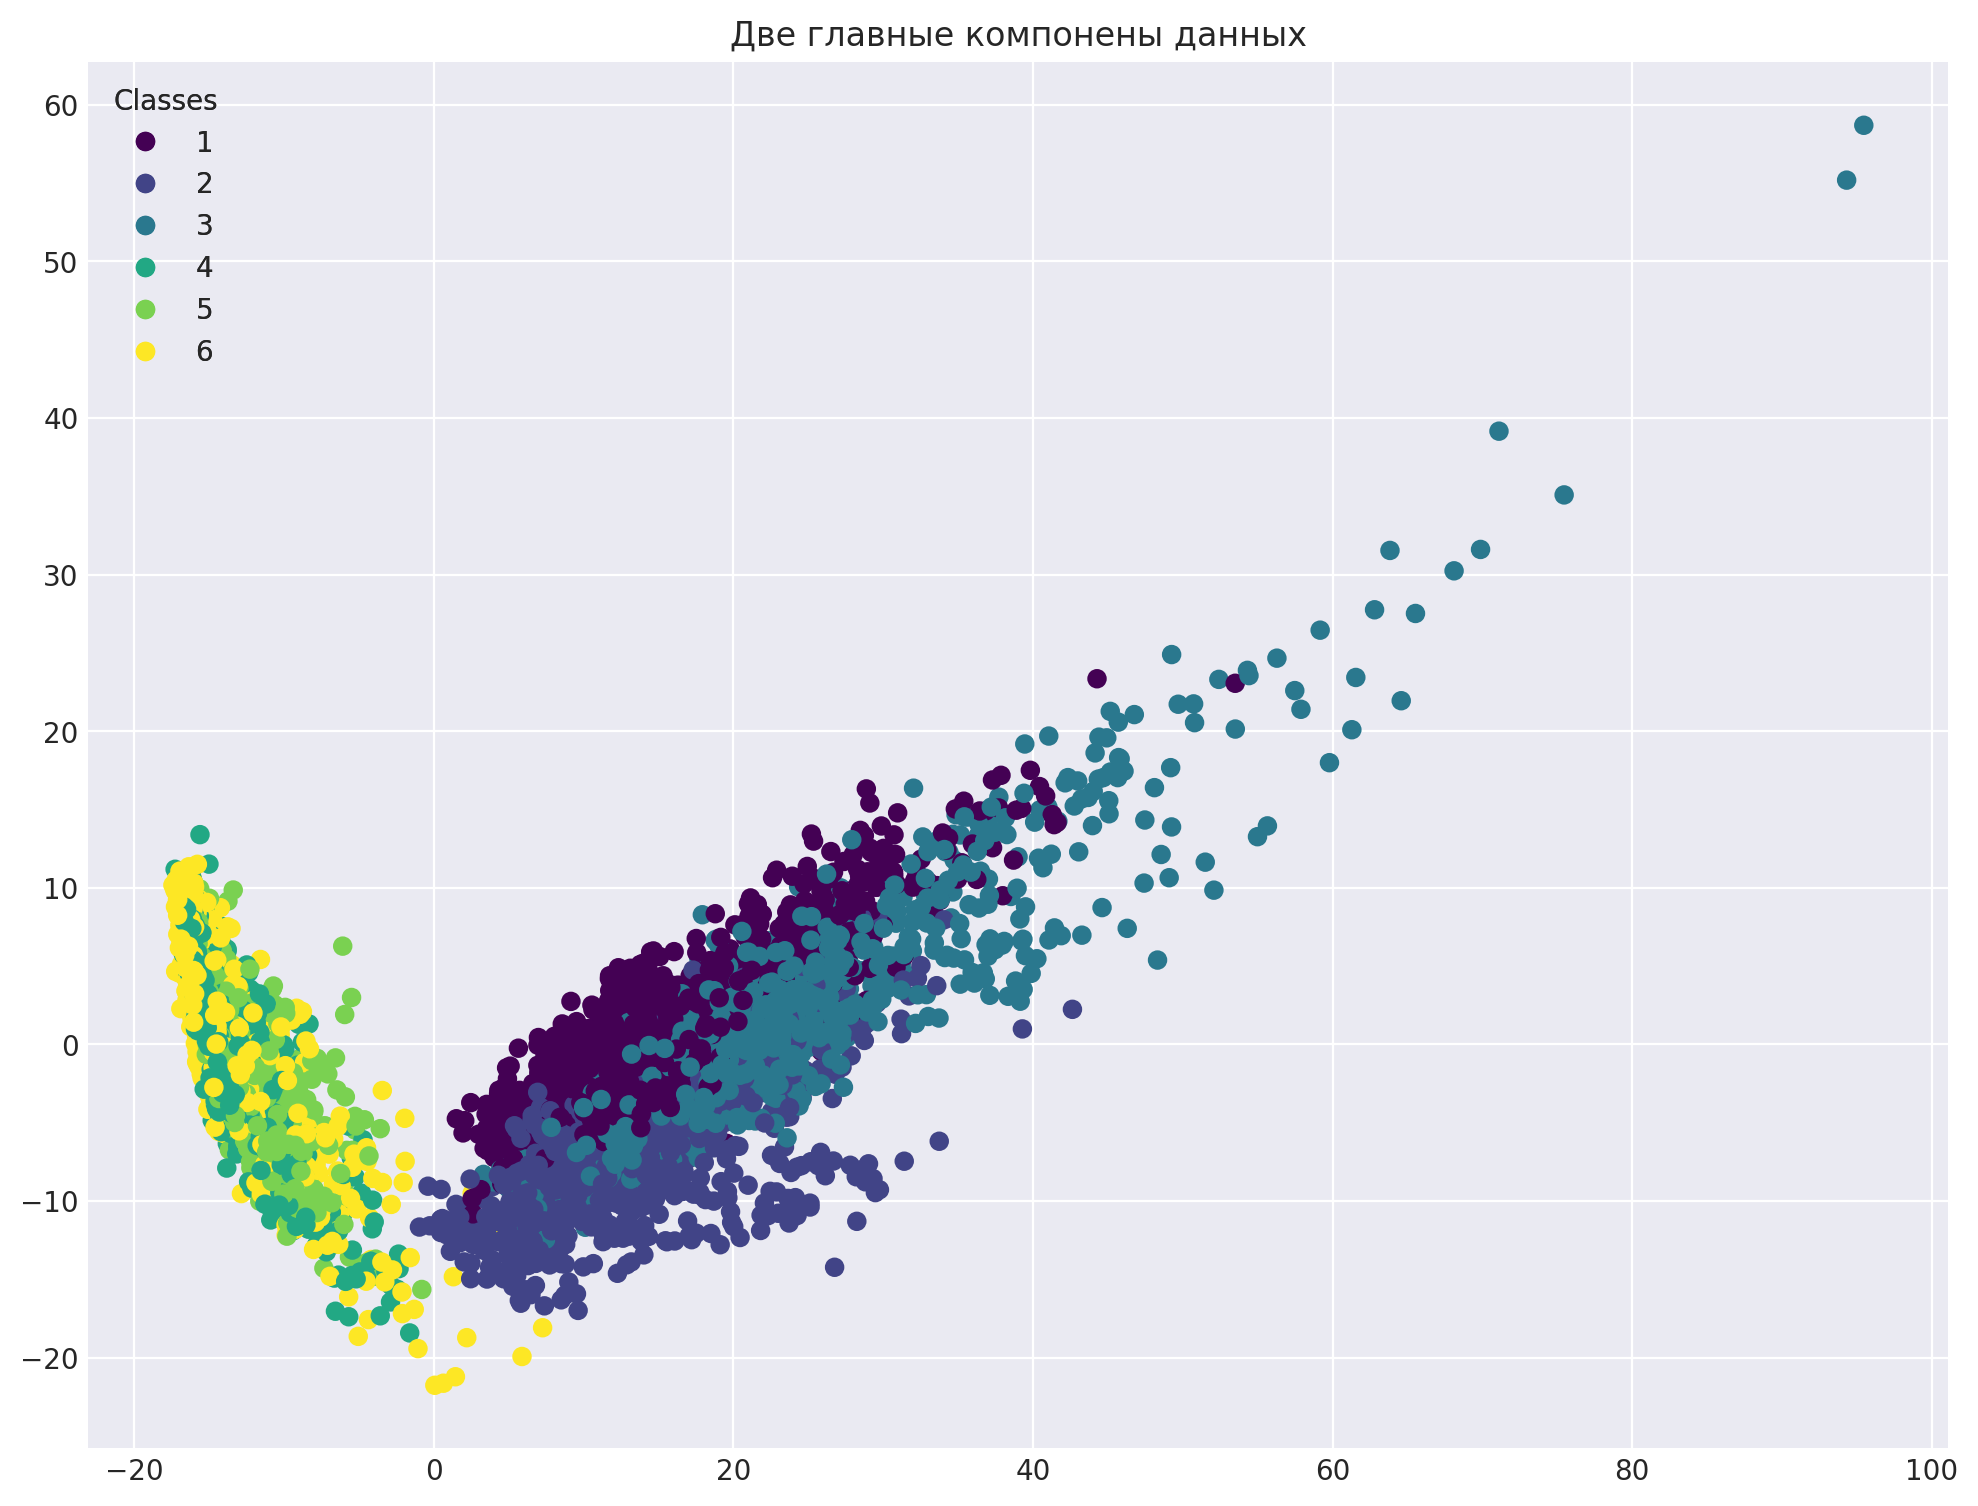

In [62]:
fig, ax = plt.subplots()

scatter = ax.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c= y, 
    cmap='viridis'
    )

legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.title('Две главные компонены данных')
plt.show()

In [165]:
def clustering(data, labels, model):
    '''
    Функция принимает на вход:
    * data - данные для кластеризации
    * labels - вектор истинных меток
    * model - алгоритм кластеризации

    Функция выводит на экран:
    * визуализацию кластеризации выбранным алгоритмом 
    * различные метрики получившейся кластеризации 
    * время работы алгоритма - обучение + инференс

    Функция возвращает: 
    * вектор предстказанных меток классов
    '''

    start_time = time()

    label_model_clustering = model.fit_predict(data)

    end_time = time()

    fig, ax = plt.subplots()
    scatter = ax.scatter(
        X_pca[:, 0], 
        X_pca[:, 1], 
        c= label_model_clustering, 
        cmap='viridis'
        )

    legend = ax.legend(*scatter.legend_elements(), title= "Classes")
    ax.add_artist(legend)

    plt.title(f'Кластеризация {model.__class__.__name__} для двух компонент данных пониженной размерности')
    plt.show()

    # время работы алгоритма
    elapsed_time = end_time - start_time
    

    print(f'Метрики кластеризации для {model.__class__.__name__}:\n\
    Индекс Рэнда: {rand_score(labels, label_model_clustering)}\n\
    Согласованный индекс Рэнда: {adjusted_rand_score(labels, label_model_clustering)}\n\
    Оценка скорректированной взаимной информации: {adjusted_mutual_info_score(labels, label_model_clustering)}\n\
    Гомогенность: {homogeneity_score(labels, label_model_clustering)}\n\
    Полнота: {completeness_score(labels, label_model_clustering)}\n\
    V-мера: {v_measure_score(labels, label_model_clustering)}\n\
    Индекс Фаулкса-Мэллоуза: {fowlkes_mallows_score(labels, label_model_clustering)}\n\
    Коэффициент силуэта:{silhouette_score(data, label_model_clustering, metric="euclidean")}\n\
    \n\
Время работы алгоритма: {round(elapsed_time, 1)} c.')
    
    return label_model_clustering

### Задание 1.4 (0.4 балла)

Сделайте кластеризацию данных методом ```KMeans```, обучив модель на данных со сниженной за счет ```PCA```
размерностью. В данном случае нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

Параметры:

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

### Задание 1.5 (0.2 балла)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

### Задание 1.6 (0.3 баллов)

Выберите какие-то метрики (минимум две) из известных вам или из методички (ссылка в начале дз, пункт 2.3.10), объясните ваш выбор.

Выведите на экран значения метрик качества кластеризации и используйте их далее.

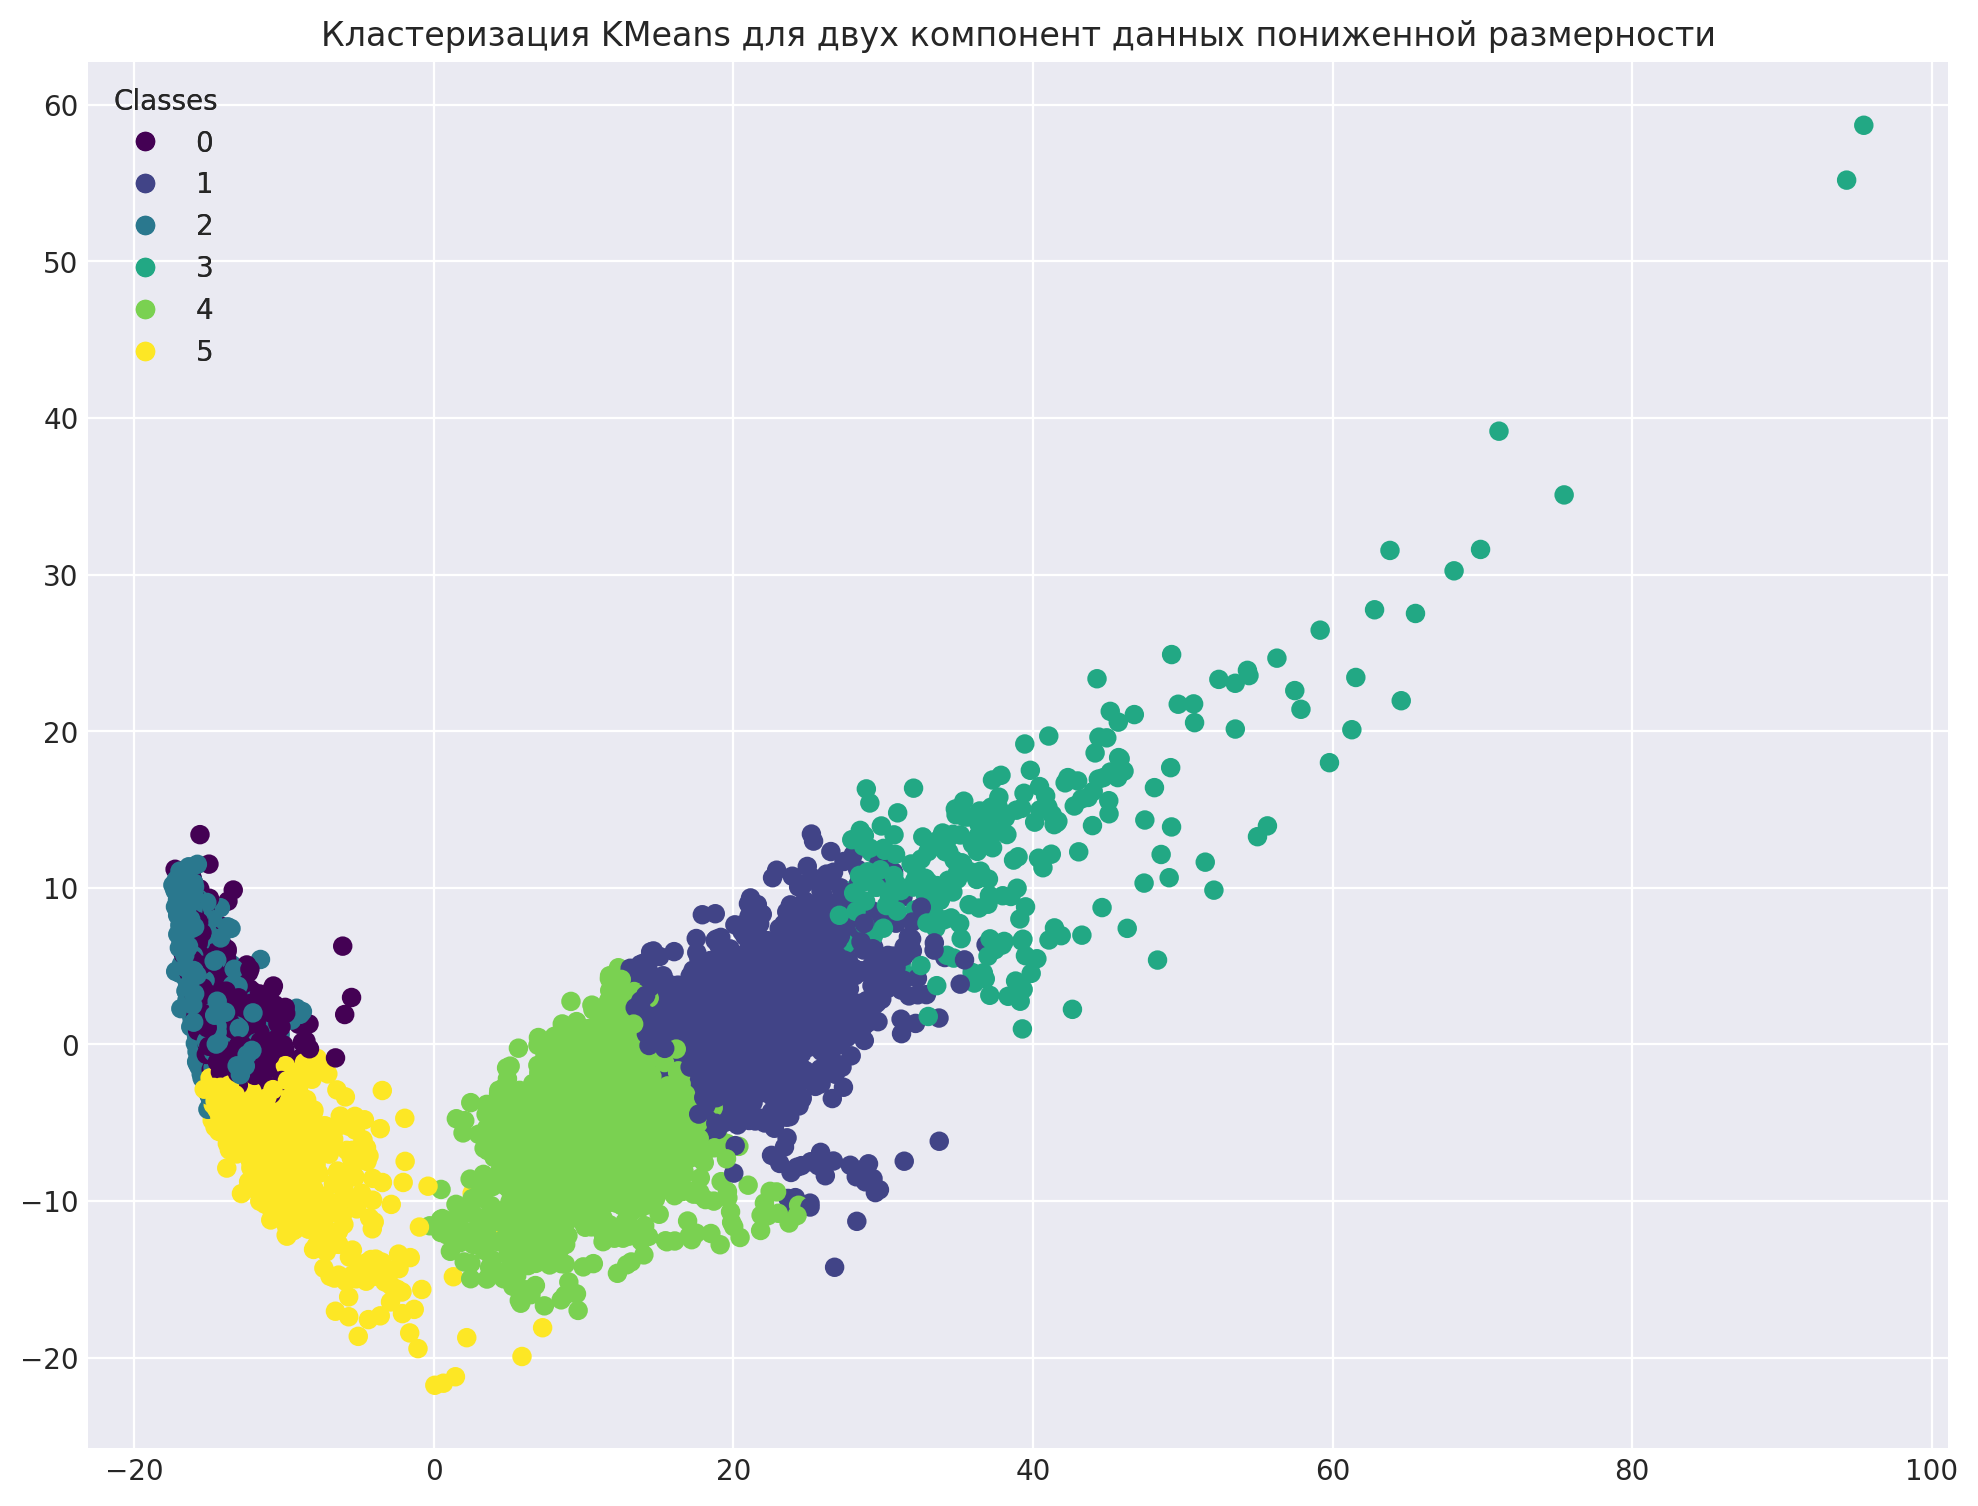

Метрики кластеризации для KMeans:
    Индекс Рэнда: 0.8254716590119944
    Согласованный индекс Рэнда: 0.42003312787137564
    Оценка скорректированной взаимной информации: 0.5586813698822077
    Гомогенность: 0.5415650822761519
    Полнота: 0.5778435239850583
    V-мера: 0.5591164367673018
    Индекс Фаулкса-Мэллоуза: 0.5278819918873031
    Коэффициент силуэта:0.1396888568200254
    
Время работы алгоритма: 1.6 c.


In [168]:
kmeans = KMeans(n_clusters= 6, random_state=RANDOM_STATE, n_init= 100)

_ = clustering(X_pca, y, kmeans)

# your text here

### Задание 1.7 (0.8 баллов)
Теперь попробуем сделать кластеризацию с помощью ```AgglomerativeClustering```.

Вновь визуализируйте данные с раскраской по полученным меткам и выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

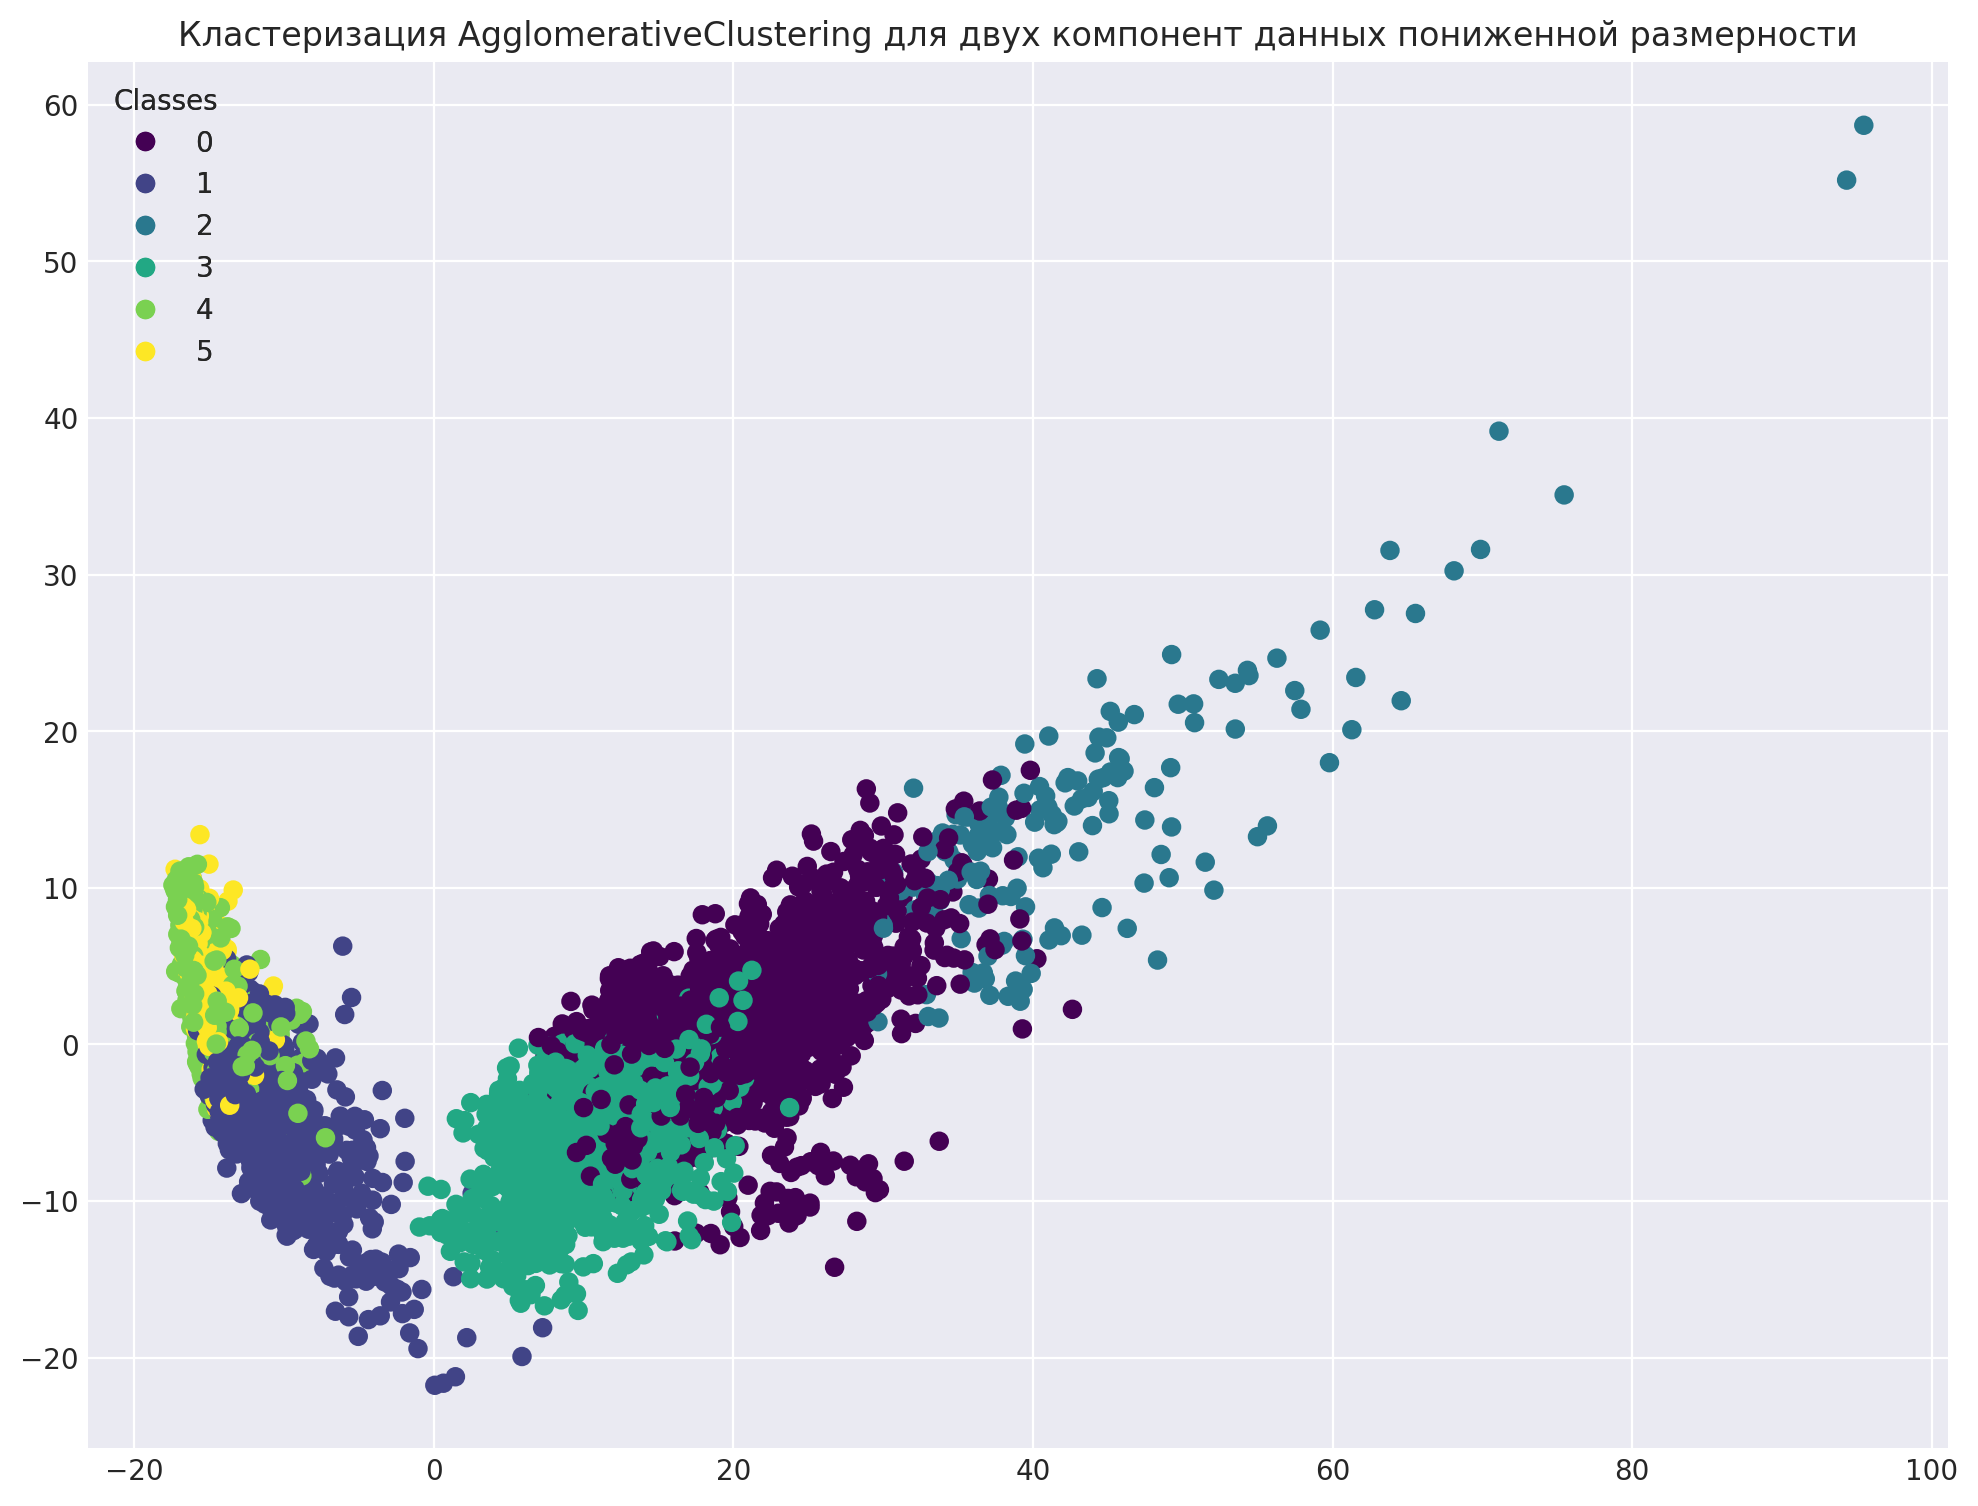

Метрики кластеризации для AgglomerativeClustering:
    Индекс Рэнда: 0.8298729537067862
    Согласованный индекс Рэнда: 0.4313534982128296
    Оценка скорректированной взаимной информации: 0.5960382517930892
    Гомогенность: 0.5771958769443585
    Полнота: 0.617005207086833
    V-мера: 0.5964370093879738
    Индекс Фаулкса-Мэллоуза: 0.5362414684777803
    Коэффициент силуэта:0.10018455746104535
    
Время работы алгоритма: 2.2 c.


In [166]:
agg_clustering = AgglomerativeClustering(n_clusters= 6)

_ = clustering(X_pca, y, agg_clustering)

# your text here

### Задание 1.8 (0.8 баллов)

Попробуйте применить другие методы кластеризации из sklearn.  Засеките время обучения и время инференса. Также вычислите метрики качества, визуализируйте результаты, после чего сделайте вывод о том, какой метод сработал лучше.

In [ ]:
dbscan = DBSCAN()
mb_kmeans = MiniBatchKMeans(n_clusters= 6, random_state=RANDOM_STATE)
optics = OPTICS()
spec_clustering = SpectralClustering(n_clusters= 6)




# your text here

### Задание 1.9 (1 балл)
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

# your text here

## Задание 2. Разделение изображения на семантические компоненты (5 баллов)

![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. 

Проверим их на ```duck.jpg``` и ```owls.jpg```

### Задание 2.0 (0.1 балл)

Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or 
#import cv2

### Задание 2.1 (1.5 балла)
Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$, где 
$x_i$ и $y_i$ — координаты пикселя, $r_i, g_i, b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### Задание 2.2 (1.5 балла)
Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

Подсказка: ```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2``` 

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### Задание 2.3 (0.9 баллов)
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

In [ ]:
#your code here

### Задание 2.4 (1 балл)
Найдите интересную картинку милого животного и примените алгоритмы и к ней. Поэкспериментируйте с параметрами алгоритмов. Картинку нужно будет загрузить вместе с работой. Слишком большие лучше не брать - считаться будет долго. Не забудьте визуализировать!

Сравните два подхода и сегментации, к которым они приводят.
Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

In [ ]:
#your code here

# your text here